Dataset shape: (181, 11)

Column names:
['Unnamed: 0', 'Player', 'Mat', 'Inns', 'Overs', 'Mdns', 'Runs', 'Wkts', 'Ave', 'Econ', 'SR']

First few rows:
   Unnamed: 0                   Player  Mat  Inns  Overs  Mdns  Runs  Wkts  \
0           0    Shakib Al Hasan (BAN)   94    93  347.3     3  2316   117   
1           1          TG Southee (NZ)   92    90  332.5     2  2729   111   
2           2          SL Malinga (SL)   84    83  299.5     1  2225   107   
3           3    Rashid Khan (AFG/ICC)   56    56  211.2     1  1312   103   
4           4  Shahid Afridi (ICC/PAK)   99    97  361.2     4  2396    98   

     Ave  Econ    SR  
0  19.79  6.66  17.8  
1  24.58  8.19  17.9  
2  20.79  7.42  16.8  
3  12.73  6.20  12.3  
4  24.44  6.63  22.1  

Class distribution:
Good bowlers (Ave <= 20): 58 (32.0%)
Poor bowlers (Ave > 20): 123 (68.0%)

Features used: ['Mat', 'Inns', 'Overs', 'Mdns', 'Runs', 'Wkts', 'Econ', 'SR']
Number of features: 8
Starting Forward Selection...
----------------

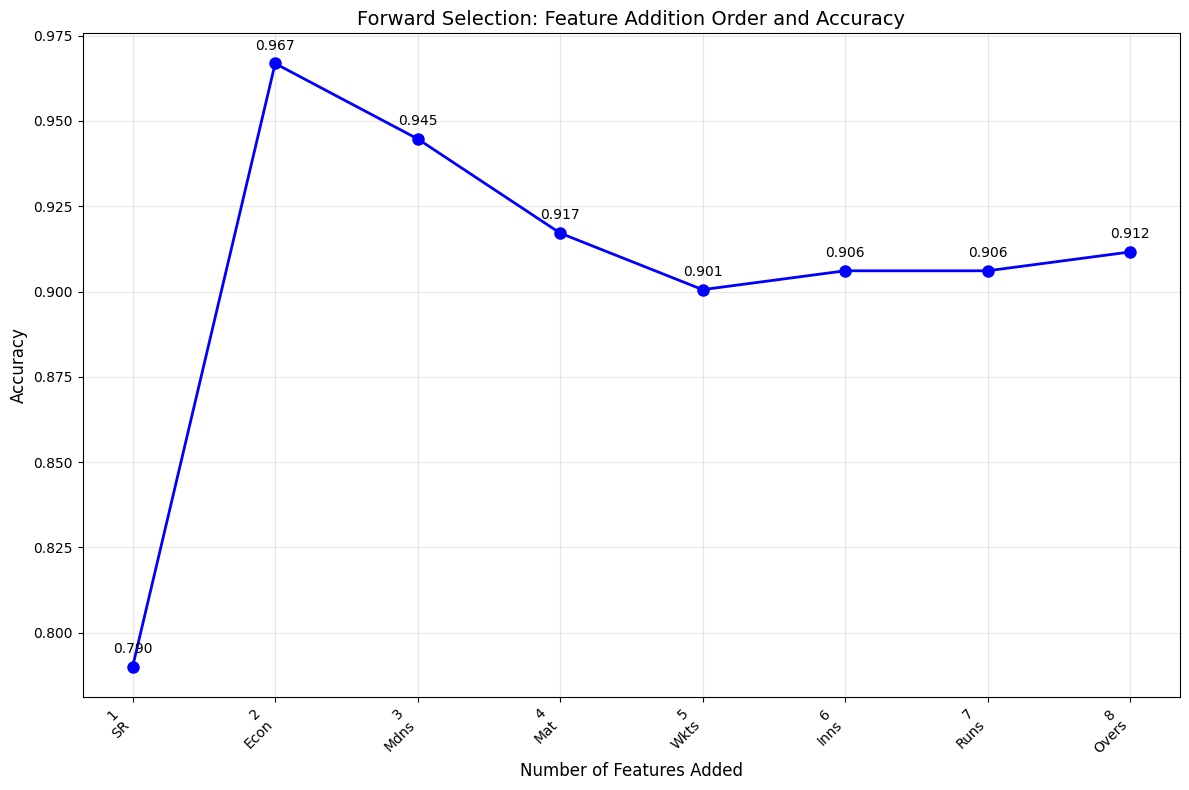


FORWARD SELECTION RESULTS:
Feature addition order:
1. SR: Accuracy = 0.7901
2. Econ: Accuracy = 0.9669
3. Mdns: Accuracy = 0.9448
4. Mat: Accuracy = 0.9171
5. Wkts: Accuracy = 0.9006
6. Inns: Accuracy = 0.9061
7. Runs: Accuracy = 0.9061
8. Overs: Accuracy = 0.9116

FEATURE ANALYSIS:
Best first feature: SR
This feature achieved accuracy: 0.7901

Second best feature: Econ
Combined accuracy with first two features: 0.9669

Best feature combination uses 2 features:
Features: ['SR', 'Econ']
Best accuracy: 0.9669

Feature impact analysis:
Adding 'Econ' improved accuracy by 0.1768
Adding 'Mdns' decreased accuracy by 0.0221
Adding 'Mat' decreased accuracy by 0.0276
Adding 'Wkts' decreased accuracy by 0.0166
Adding 'Inns' improved accuracy by 0.0055
Adding 'Runs' improved accuracy by 0.0000
Adding 'Overs' improved accuracy by 0.0055


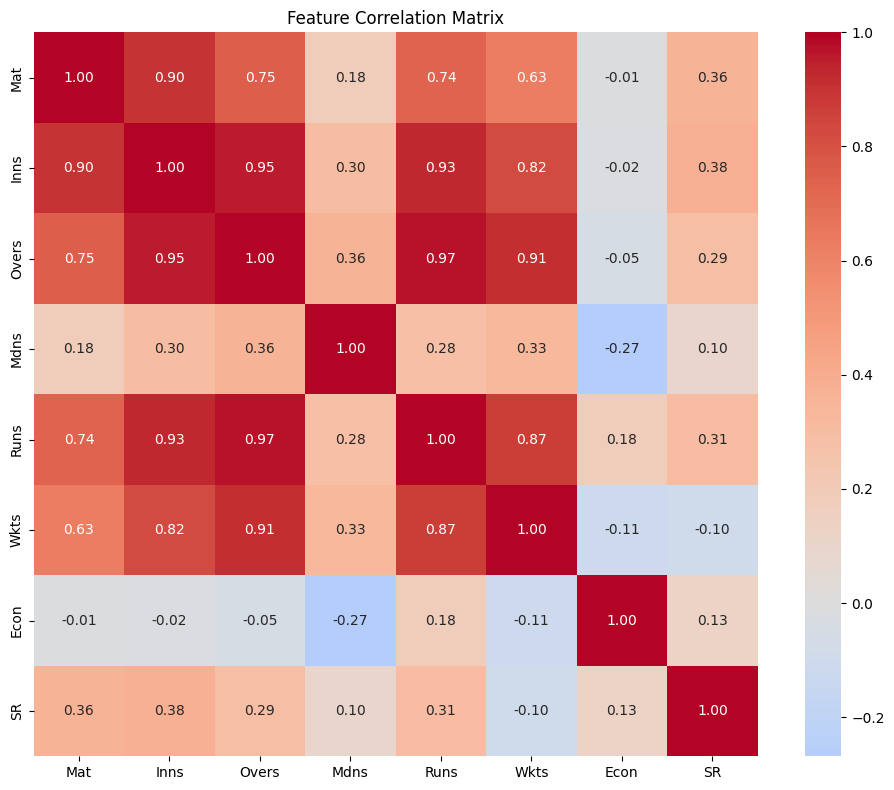

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

# Load and prepare the dataset
def load_and_prepare_data():
    """Load the cricket dataset and prepare it for classification"""

    # Read the CSV file
    df = pd.read_csv('twbo.csv')

    # Display basic info about the dataset
    print("Dataset shape:", df.shape)
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nFirst few rows:")
    print(df.head())

    # Remove non-numeric columns and player names
    numeric_columns = ['Mat', 'Inns', 'Overs', 'Mdns', 'Runs', 'Wkts', 'Ave', 'Econ', 'SR']
    X = df[numeric_columns].copy()

    # Create binary classification based on bowling average
    # Good bowlers: Ave <= 20, Poor bowlers: Ave > 20
    y = (df['Ave'] <= 20).astype(int)  # 1 for good bowlers, 0 for poor bowlers

    print(f"\nClass distribution:")
    print(f"Good bowlers (Ave <= 20): {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
    print(f"Poor bowlers (Ave > 20): {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.1f}%)")

    # Remove the 'Ave' column from features since we used it to create labels
    X = X.drop('Ave', axis=1)

    # Handle any missing values
    X = X.fillna(X.mean())

    # Normalize features (z-score normalization as mentioned in project requirements)
    scaler = StandardScaler()
    X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    print(f"\nFeatures used: {list(X.columns)}")
    print(f"Number of features: {len(X.columns)}")

    return X_normalized, y, list(X.columns)

def nearest_neighbor_classifier(X_train, y_train, X_test):
    """Simple nearest neighbor classifier implementation"""
    distances = []

    for i, test_point in enumerate(X_test.values):
        # Calculate Euclidean distance to all training points
        train_distances = np.sqrt(np.sum((X_train.values - test_point) ** 2, axis=1))
        # Find the nearest neighbor
        nearest_idx = np.argmin(train_distances)
        distances.append(y_train.iloc[nearest_idx])

    return np.array(distances)

def evaluate_feature_subset(X, y, feature_indices):
    """Evaluate a subset of features using leave-one-out cross-validation"""
    if len(feature_indices) == 0:
        return 0.0

    X_subset = X.iloc[:, feature_indices]
    loo = LeaveOneOut()
    predictions = []
    actual = []

    for train_idx, test_idx in loo.split(X_subset):
        X_train, X_test = X_subset.iloc[train_idx], X_subset.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Use our custom nearest neighbor classifier
        pred = nearest_neighbor_classifier(X_train, y_train, X_test)
        predictions.extend(pred)
        actual.extend(y_test)

    accuracy = accuracy_score(actual, predictions)
    return accuracy

def forward_selection(X, y, feature_names):
    """Implement forward selection algorithm"""
    n_features = X.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    accuracies = []
    feature_order = []

    print("Starting Forward Selection...")
    print("-" * 50)

    # Initial accuracy with no features
    base_accuracy = len(y[y == y.mode()[0]]) / len(y)  # Majority class accuracy
    print(f"Baseline accuracy (majority class): {base_accuracy:.4f}")

    while remaining_features:
        best_accuracy = 0
        best_feature = None

        # Try adding each remaining feature
        for feature_idx in remaining_features:
            current_features = selected_features + [feature_idx]
            accuracy = evaluate_feature_subset(X, y, current_features)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature_idx

        # Add the best feature
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            accuracies.append(best_accuracy)
            feature_order.append(feature_names[best_feature])

            print(f"Added feature: {feature_names[best_feature]}")
            print(f"Current features: {[feature_names[i] for i in selected_features]}")
            print(f"Accuracy: {best_accuracy:.4f}")
            print("-" * 30)
        else:
            break

    return selected_features, accuracies, feature_order

def plot_results(accuracies, feature_order):
    """Plot the forward selection results"""
    plt.figure(figsize=(12, 8))

    x_positions = range(1, len(accuracies) + 1)

    plt.plot(x_positions, accuracies, 'b-o', linewidth=2, markersize=8)
    plt.xlabel('Number of Features Added', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Forward Selection: Feature Addition Order and Accuracy', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add feature names as x-tick labels
    plt.xticks(x_positions, [f"{i}\n{feature}" for i, feature in enumerate(feature_order, 1)],
               rotation=45, ha='right')

    # Add accuracy values on the plot
    for i, acc in enumerate(accuracies):
        plt.annotate(f'{acc:.3f}', (x_positions[i], acc),
                    textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()

    # Print final results
    print("\nFORWARD SELECTION RESULTS:")
    print("=" * 50)
    print("Feature addition order:")
    for i, (feature, acc) in enumerate(zip(feature_order, accuracies), 1):
        print(f"{i}. {feature}: Accuracy = {acc:.4f}")

def analyze_features(feature_order, accuracies):
    """Provide analysis of the selected features"""
    print("\nFEATURE ANALYSIS:")
    print("=" * 50)

    if len(feature_order) > 0:
        print(f"Best first feature: {feature_order[0]}")
        print(f"This feature achieved accuracy: {accuracies[0]:.4f}")

        if len(feature_order) > 1:
            print(f"\nSecond best feature: {feature_order[1]}")
            print(f"Combined accuracy with first two features: {accuracies[1]:.4f}")

        # Find the best combination
        best_idx = np.argmax(accuracies)
        print(f"\nBest feature combination uses {best_idx + 1} features:")
        print(f"Features: {feature_order[:best_idx + 1]}")
        print(f"Best accuracy: {accuracies[best_idx]:.4f}")

        # Identify potentially harmful features
        if len(accuracies) > 1:
            print("\nFeature impact analysis:")
            for i in range(1, len(accuracies)):
                if accuracies[i] < accuracies[i-1]:
                    print(f"Adding '{feature_order[i]}' decreased accuracy by {accuracies[i-1] - accuracies[i]:.4f}")
                else:
                    print(f"Adding '{feature_order[i]}' improved accuracy by {accuracies[i] - accuracies[i-1]:.4f}")

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    X, y, feature_names = load_and_prepare_data()

    # Run forward selection
    selected_features, accuracies, feature_order = forward_selection(X, y, feature_names)

    # Plot results
    plot_results(accuracies, feature_order)

    # Analyze results
    analyze_features(feature_order, accuracies)

    # Display correlation matrix to understand feature relationships
    plt.figure(figsize=(10, 8))
    correlation_matrix = X.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()